## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '.'
WORKING_DIR = "."

## Extract Image Features

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [5]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

# Define or load your pre-trained model
# For example:
# from keras.applications import VGG16
# model = VGG16(...)

# Define BASE_DIR
BASE_DIR = r"C:\Users\admin\SEM_6\Sem6_projects\AOML"

features = {}
directory = os.path.join(BASE_DIR, 'Img')

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    
    # Convert image pixels to numpy array
    image = img_to_array(image)
    
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # Preprocess image for the model
    image = preprocess_input(image)
    
    # Extract features
    feature = model.predict(image, verbose=0)
    
    # Get image ID
    image_id = img_name.split('.')[0]
    
    # Store feature
    features[image_id] = feature


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.04it/s]


In [6]:
import os
import pickle

# Ensure WORKING_DIR exists
WORKING_DIR = "C:/Users/admin/SEM_6/Sem6_projects/AOML"  # Update with the correct path
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)

# Normalize path separators
pickle_file_path = os.path.join(WORKING_DIR, 'features.pkl')
pickle_file_path = os.path.normpath(pickle_file_path)

# Store features in pickle
with open(pickle_file_path, 'wb') as f:
    pickle.dump(features, f)


In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [36]:
with open(os.path.join(BASE_DIR, 'cap1.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [37]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<?, ?it/s]


In [38]:
len(mapping)

24

## Preprocess Text Data

In [39]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [40]:
# before preprocess of text
mapping['s1']

[' "Shreyash enjoying the serene riverside view."',
 ' "A peaceful day by the river with Shreyash."',
 ' "Shreyash standing by the flowing waters  embracing nature."',
 ' "Taking in the tranquility of the river  Shreyash stands still."',
 ' "A moment of calm for Shreyash beside the river."']

In [41]:
# preprocess the text
clean(mapping)

In [42]:
# after preprocess of text
mapping['s31']

['startseq "shreyash tunes into his workout at the gym." endseq',
 'startseq "focused on fitness shreyash captures his gym routine." endseq',
 'startseq "shreyashs gym session blend of concentration and strength." endseq',
 'startseq "mirror reflection of shreyashs dedication at the gym." endseq',
 'startseq "shreyash in the zone prepping for his workout." endseq']

In [43]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [44]:
len(all_captions)

120

In [45]:
all_captions[:10]

['startseq "shreyash enjoying the serene riverside view." endseq',
 'startseq "a peaceful day by the river with shreyash." endseq',
 'startseq "shreyash standing by the flowing waters embracing nature." endseq',
 'startseq "taking in the tranquility of the river shreyash stands still." endseq',
 'startseq "a moment of calm for shreyash beside the river." endseq',
 'startseq "shreyash giving peace sign by the crystal waters of the lake." endseq',
 'startseq "shreyashs selfie captures the essence of the majestic lake." endseq',
 'startseq "a scenic lakeside memory with shreyash." endseq',
 'startseq "under the open sky shreyash finds peace by the lake." endseq',
 'startseq "shreyashs vibrant presence complements the serene lake." endseq']

In [46]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [47]:
vocab_size

429

In [48]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

15

## Train Test Split

In [49]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [50]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [51]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key in data_keys:
            n += 1
            photo = features[key][0]
            for desc in mapping[key]:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Handle out-of-vocabulary words
                    if out_seq >= vocab_size:
                        # Skip this word or handle it as needed
                        continue
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n = 0


## Model Creation

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, add
from tensorflow.keras.utils import plot_model

# Assuming 'max_length' and 'vocab_size' are predefined
max_length = 100  # Example value, specify according to your dataset
vocab_size = 8485  # Example value, specify according to your dataset

# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model structure
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 256)             2172160   ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_4[0][0]']             
                                                                                            

In [53]:
# train the model
epochs = 100
batch_size = 5
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

4/4 [==============================] - 27s 6s/step - loss: 0.9545


In [25]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')


C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from keras.models import load_model

In [22]:
model=load_model('best_model.h5')

## Generate Captions for the Image

In [54]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [55]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [56]:
def predict_caption(image, tokenizer, max_length, model):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=100)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text


In [57]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 256)             2172160   ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_4[0][0]']             
                                                                                            

In [58]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(features[key], tokenizer, max_length,model) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.07s/it]

BLEU-1: 0.524749
BLEU-2: 0.145296



C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


## Visualize the Results

In [95]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Img", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    
        
    # predict the caption
    y_pred = predict_caption(features[image_id], tokenizer, max_length,model)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Predicted--------------------
startseq shreyash caught action action during boxing spar endseq


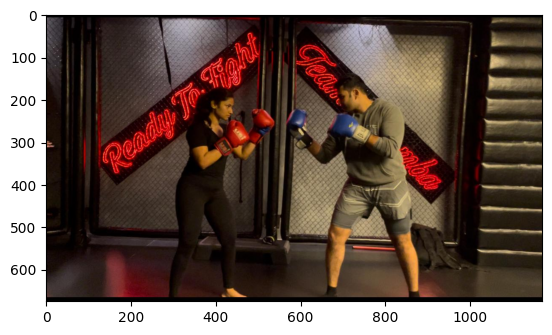

In [96]:
generate_caption("s4.jpeg")

--------------------Predicted--------------------
startseq shreyash enjoying the serene riverside view endseq


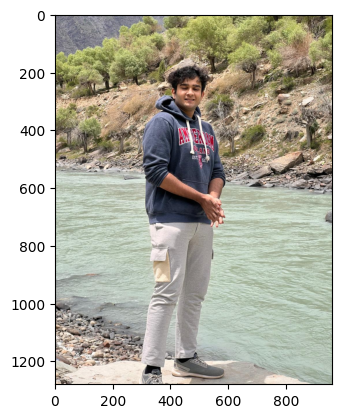

In [97]:
generate_caption("s1.jpeg")

--------------------Predicted--------------------
startseq shreyashs beach walk is about the the waves and breeze endseq


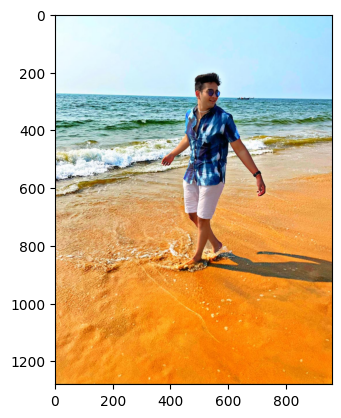

In [99]:
generate_caption("s22.jpeg")